# **Lesson 08**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

In [3]:
# plot parameters
import sys
sys.path.append('./../Libraries/')
import plt_params
%matplotlib inline

The variational principle in Quantum Mechanics states that the expectation value of the Hamiltonian over a (good) trial quantum state has the ground state energy $E_0$ as lower bound:

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

During this exercise you will variationally optimize the ground state of a single quantum particle in a one dimensional (1D) space confined by the following external potential:
$$
V(x) = x^4 - \frac{5}{2}x^2
$$

This 1D quantum model is not analytically solvable and should be attacked by numerical methods. In order to obtain an approximate wave function for the ground state, the Variational Monte Carlo method uses a trial wave function, parametrized by a set of variational parameters. An approximate model for the ground state wave function is the following trial wave function:
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

$\Psi_T^{\sigma,\mu}(x)$ depends on two variational parameters: $\sigma$ and $\mu$.

# Exercise 08.1

Write a Variational Monte Carlo code for a single quantum particle in 1D which exploits the Metropolis algorithm to sample the square modulus of our trial wave function $|\Psi_T^{\sigma,\mu}(x)|^2$ using an uniform transition probability $T(x_{new}|x_{old})$. By using data blocking, the code should be able to compute the expectation value for the Hamiltonian

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$

which can be used to find the parameters that minimize this quantity. Use $\hbar = 1$ and $m=1$.
Note that to measure $\langle {\hat H} \rangle_T$ you need the analytical calculation of:
    
$$
\frac{{-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}} \Psi_T^{\sigma,\mu}(x)}{\Psi_T^{\sigma,\mu}(x)}
$$

### Supplementary material

How can we describe a wave function as a vector? We set up a lattice of discrete points, spaced by a constant distance $dx$, and record the value of the function at each lattice point. In this way the wave function, $\Psi(x)$ become a vector:

$$
\Psi(x) \to \left[ \Psi(x_1), \Psi(x_2), ..., \Psi(x_N) \right] = 
\left[ \Psi_1, \Psi_2, ..., \Psi_N \right]
$$

The time independent Schrodinger equation 

$$
{\hat H} \Psi(x) = \left( -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + V(x) \right) \Psi(x) = E \Psi(x)
$$

can be written in matrix form. But how do we write the second derivative at a particular point? Let's start with the first derivatives:
$$
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) \simeq \frac{\Psi_{i+1}-\Psi_{i}}{dx}\\
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right) \simeq \frac{\Psi_{i}-\Psi_{i-1}}{dx}
$$

Thus, we can discretize the second derivative in the following way:
$$
\frac{\partial^2}{\partial x^2} \Psi(x=x_i) =
\frac{\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) - \frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right)}{dx} =
\frac{\Psi_{i+1}-2\Psi_{i}+\Psi_{i-1}}{dx^2}
$$

We finally obtain:

$$
\begin{bmatrix}
 \frac{\hbar^2}{m\,dx^2}+V(x_1)& -\frac{\hbar^2}{2m\,dx^2} & 0 & \dots  & 0 \\
-\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_2) & -\frac{\hbar^2}{2m\,dx^2} & \dots  & 0 \\
 0                        & -\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_3) & \dots  & 0 \\
 \vdots                   & \vdots                    & \vdots & \ddots & \vdots \\
 0                    & 0                & 0 & \dots  & \frac{\hbar^2}{m\,dx^2}+V(x_N)
\end{bmatrix}
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
= E
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
$$

To solve the time independent Schrodinger equation we therefore have to find eigenstates and eigenvalues of the matrix just obtained.

In [4]:
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

Ground state energy:  -0.4604658796926825
1st excited state energy:  0.09742471331760562
2nd excited state energy:  1.9717331343931928


## Solution

To compute the integral:

$$ \langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)} {\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)} = 
\int dx \, \varphi(x) \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)} \ , $$

we can use the method of exercise $2.1$, so we can sample the probability distribution $\varphi(x)$ and then evaluate the sum:

$$ \sum_{i=1}^N \frac{\hat H \Psi_T(x_i)}{\Psi_T(x_i)} $$

in the sampled points $x_i$. To do so we need to know how the hamiltonian acts on the wave function, we need therefore to compute:

$$ \frac{\hat H \Psi_T(x)}{\Psi_T(x)} = 
\frac{1}{\Psi_T(x)} \left[-\frac{\hbar}{2m} \frac{\partial^2}{\partial x^2} + V(x)\right]\Psi_T(x) =
-\frac{\hbar}{2m} \frac{1}{\Psi_T(x)} \frac{\partial^2 \Psi_T(x)}{\partial x^2} + V(x) = 
\frac{\hat T \Psi_T(x)}{\Psi_T(x)} + V(x) \ . $$

After some calculations, setting $\hbar = m = 1$, the first term becomes:

$$ \frac{\hat T \Psi_T(x)}{\Psi_T(x)} = 
- \left( \frac{1}{2 \sigma^2 \Psi_T(x)} \right) \left[ \left( \frac{(x-\mu)^2}{\sigma^2} - 1 \right) e^{-\frac{(x-\mu)^2}{2\sigma^2}} + \left( \frac{(x+\mu)^2}{\sigma^2} - 1 \right) e^{-\frac{(x+\mu)^2}{2\sigma^2}} \right] \ , $$

while the potential is:

$$ V(x) = x^4 - \frac{5}{2}x^2 \ . $$

### Code

To tackle this integral I combined my `Metropolis` class to a derived class of `BlockingAverage` called `BA_SimAnn`. Firstly I set the $M(RT)^2$ step to get an acceptance rate of $50\%$ and then the `BA_SimAnn` loops over the block length and evaluate the hamiltonian, for which I used (as well as for the wave function and its square) a `function` object.

Here I show the code for blocking average:
```c++
double BA_SimAnn :: Increase() {
    double val = 0.;
    if(save_) {
        std::ofstream out("sampling.csv", std::ios::app);
        for(int i=0 ; i<dim_ ; i++) {
            metro_.Propose();
            metro_.Accept();
            arma::vec x = metro_.GetPoint();
            out << i+1 << "," << x[0] << std::endl;
            val += H_(x);
        }
        out.close();
    }
    else {
        for(int i=0 ; i<dim_ ; i++) {
            metro_.Propose();
            metro_.Accept();
            arma::vec x = metro_.GetPoint();
            val += H_(x);
        }
    }

    return val/dim_;
}
```

As it can be seen looking at the code, the `save_` option allows to save the sampling in a file `.csv` to draw a sketch of the wave function.

In [5]:
blocks_0_1, energy_0_1, errors_0_1 = np.loadtxt('08.1/energy_m=0.0_s=1.0.csv', delimiter=',', skiprows=1, unpack=True, usecols=(0,2,3))
blocks_1_05, energy_1_05, errors_1_05 = np.loadtxt('08.1/energy_m=1.0_s=0.5.csv', delimiter=',', skiprows=1, unpack=True, usecols=(0,2,3))

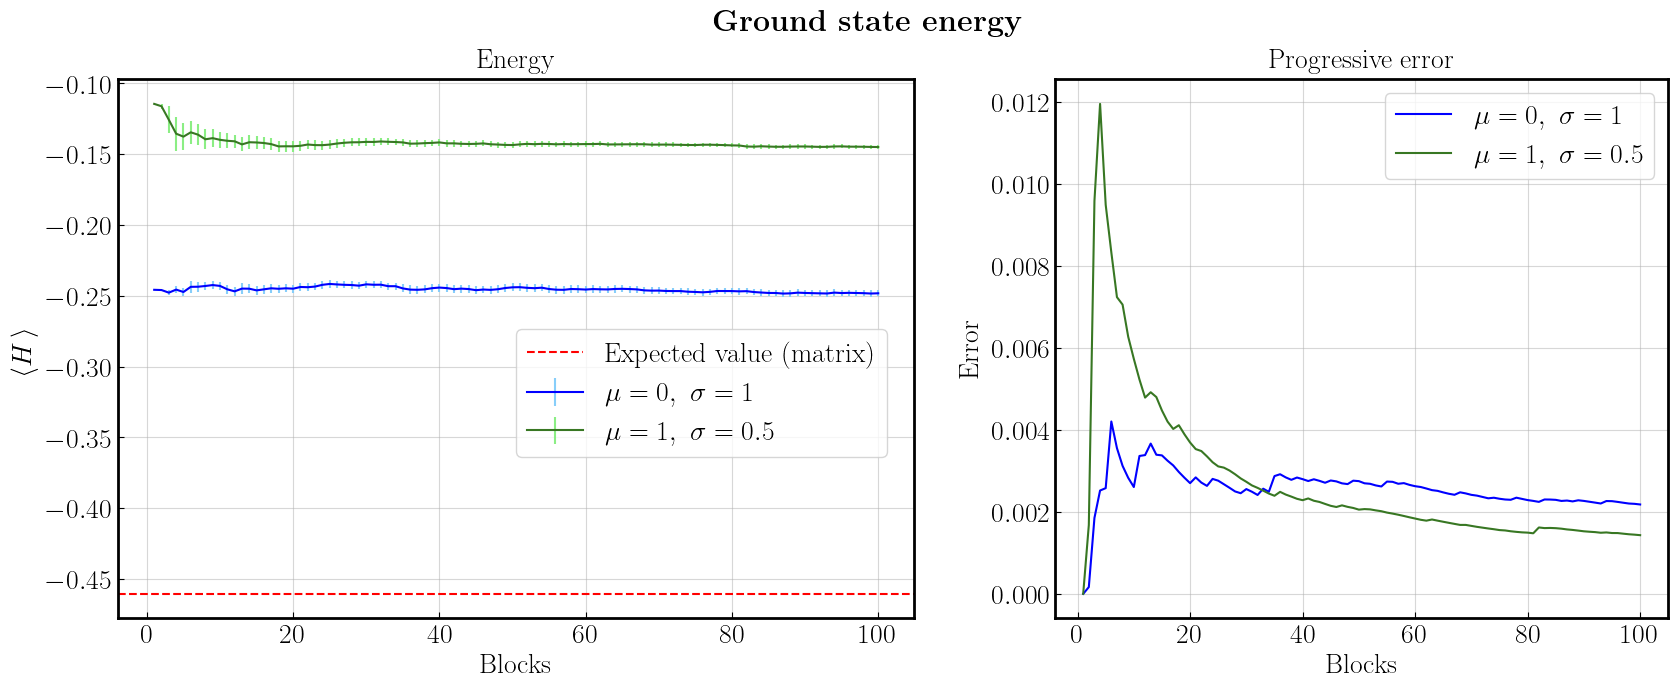

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7), gridspec_kw={'width_ratios': [1.3, 1]})
fig.suptitle(r'\textbf{Ground state energy}', fontsize=22)

axs[0].errorbar(blocks_0_1, energy_0_1, yerr=errors_0_1, c='blue', ecolor='lightskyblue', label='$\mu=0, \ \sigma=1$')
axs[0].errorbar(blocks_1_05, energy_1_05, yerr=errors_1_05, c='#387723', ecolor='#8BEE84', label='$\mu=1, \ \sigma=0.5$')
axs[0].axhline(y=E[0], c='red', linestyle='--', label='Expected value (matrix)')

axs[0].set_xlabel('Blocks')
axs[0].set_ylabel(r'$\langle H \, \rangle$', labelpad=6)
axs[0].set_title('Energy', pad=8)
axs[0].legend(loc=(0.5,0.3))

axs[1].plot(blocks_0_1, errors_0_1, c='blue', label='$\mu=0, \ \sigma=1$')
axs[1].plot(blocks_1_05, errors_1_05, c='#387723', label='$\mu=1, \ \sigma=0.5$')

axs[1].set_xlabel('Blocks')
axs[1].set_ylabel('Error', labelpad=6)
axs[1].set_title('Progressive error', pad=8)
axs[1].legend()

plt.show()

**Plot parameters**:
- Total steps: $10^6$
- Blocks: $100$
- Steps in each block: $10^4$

In [7]:
points_0_1 = np.genfromtxt("08.1/sampling_m=0.0_s=1.0.csv", delimiter=',', skip_header=1)
points_1_05 = np.genfromtxt("08.1/sampling_m=1.0_s=0.5.csv", delimiter=',', skip_header=1)

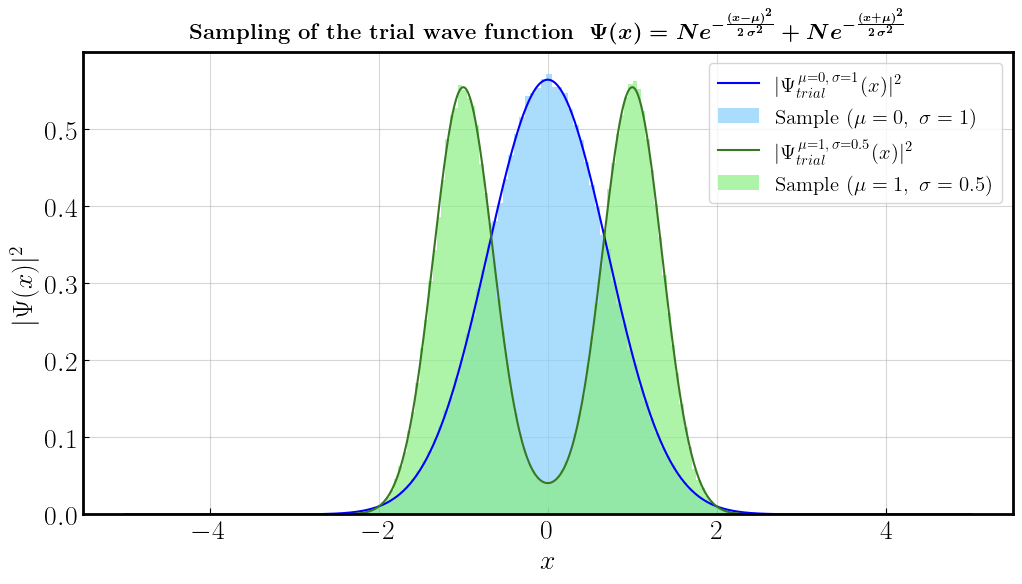

In [8]:
# plotting the sampling of the wave function
def wave_func(x, mu, sigma) :
    norm = 2 * sigma * np.sqrt(np.pi) * (1 + np.exp(-(mu**2) / (sigma**2)))
    return (1/norm) * (np.exp(-(x - mu)**2 / (2*sigma**2)) + np.exp((-(x + mu)**2 / (2*sigma**2))))**2

fig = plt.figure(figsize=(12, 6))
plt.plot(x, wave_func(x, 0, 1), c='blue', label='$|\Psi_{trial}^{\, \mu=0, \, \sigma=1}(x)|^2$')
hist_0_1 = plt.hist(points_0_1, bins=100, density=True, color='lightskyblue', alpha=0.7, label="Sample $(\mu=0, \ \sigma=1)$")
plt.plot(x, wave_func(x, 1, 0.5), c='#387723', label='$|\Psi_{trial}^{\, \mu=1, \, \sigma=0.5}(x)|^2$')
hist_1_05 = plt.hist(points_1_05, bins=100, density=True, color='#8BEE84', alpha=0.7, label="Sample $(\mu=1, \ \sigma=0.5)$")

plt.xlabel('$x$')
plt.ylabel('$|\Psi(x)|^2$')
plt.title(r'\textbf{Sampling of the trial wave function } \boldmath $\Psi(x) = Ne^{-\frac{(x-\mu)^2}{2\,\sigma^2}} + Ne^{-\frac{(x+\mu)^2}{2\,\sigma^2}}$', pad=10, fontsize=16)
plt.legend(fontsize=15)
plt.show()

This histogram represents the sampling of the trial wave function using Metropolis algorithm, with two different sets of parameters $\mu$ and $\sigma$: the sampling resemble very closely the trial analytic wave function.
Here there is the expression of the (normalized) trial wave function: 

$\Psi_T(x) = \dfrac{1}{2  \sigma \sqrt{\pi}  \Big(1 + e^{-\frac{\mu^2}{\sigma^2}}\Big)}  \left( e^{-\frac{(x - \mu)^2}{2 \sigma^2}} + e^{-\frac{(x + \mu)^2}{2 \sigma^2}} \right)$

# Exercise 08.2

To find the parameters $\sigma$ and $\mu$ which minimize $\langle {\hat H} \rangle_T$, extend your Variational Monte Carlo code to face the variational optimization problem via a Simulated Annealing (SA) algorithm.

Choose an appropriate starting temperature for your SA algorithm and an appropriate temperature-update-law to make the optimization work.

Compute $\langle {\hat H} \rangle_T$ with enough statistics in order to be able to measure the lowering of $\langle {\hat H} \rangle_T$ once the variational parameters are moved.

- Show a picture of $\langle {\hat H} \rangle_T$ (with statistical uncertainties) as a function of the SA steps of the algorithm
- you could also show a picture of the trajectory of the SA algorithm in the variational parameter space as a function of the SA steps
- show a picture of the estimation of $\langle {\hat H} \rangle_T$ and its statistical uncertainty as a function of the number of blocks/MC steps for the set of parameters which minimize $\langle {\hat H} \rangle_T$
- show also a picture **of the sampled** $|\Psi_T(x)|^2$ by filling a histogram with the sampled configurations, moreover compare it with the analytic curve of $|\Psi_T(x)|^2$ and with the numerical solution obtained by transforming the Schrodinger equation into a matrix equation (see below the supplementary material).

## Solution

To optimize parameters $\mu$ and $\sigma$ in order to reach the ground state of the system, I have implemented an algorithm exploiting the **Simulated Annealing** method. This is an optimization technique that maps the problem we want to solve onto a physical system cooling down. If the cooling of the system is slow enough, all the slowing down particles will have time to explore all the phase space and to find the correct minimum of the energy. Thus we let our parameters vary giving them a mobility proportional to the temperature of the physical system, then we accept or reject the steps considering previous and current energy, and then we take the temperature towards zero.

After having initialized the parameters $(\mu = 1, \ \sigma = 1)$ and the temperature $(T = 1)$, the algorithm I used follows this steps:
1. decrease the temperature $T \propto i^{-1}$, where $i$ is the counter for the MC steps
2. propose a step for the parameters, adding them a correction $\delta \sim \mathcal N(0, \delta_0T)$
3. compute the value of the hamiltonian $E_{new}$ as I have done in exercise $08.1$, using the $M(RT)^2$ algorithm to sample the trial wave function
4. accept or reject the correction to the parameters with probability 
$$ \alpha = \min \Big[ 1, \exp{\big(-\beta(E_{new} - E_{old})\big)} \Big] $$

This steps are performed until the temperature reaches the desired value, I chose to take $1000$ steps evolving temperature from $T_0 = 1$ to $T_{1000} = 0.001$.

### Code

Here I show the implementation of the fundamental steps of the simulated annealing;
```c++
for(int i=0 ; i<N ; i++) {
        beta = i+1;
        T = 1./beta;
        Progress_Bar(i, N-1);

        // updating parameters
        d_mu = d_mu > mu_old ? mu_old : delta_mu;
        d_sigma = d_sigma > sigma_old ? sigma_old : delta_sigma;
        mu = std::fabs(mu_old + rnd.Gauss(0.,d_mu*T/T0));
        sigma = std::fabs(sigma_old + rnd.Gauss(0.,d_sigma*T/T0));

        psi.SetParameters(mu, sigma);
        H.SetParameters(mu, sigma);

        /* blocking average of the hamiltonian evaluation */

        // acception/rejection
        alpha = std::min(1., std::exp(-beta * (ene - ene_old)));
        r = rnd.Rannyu();
        if(r < alpha) {
            mu_old = mu;
            sigma_old = sigma;
            if(ene < ene_best) {
                mu_best = mu;
                sigma_best = sigma;
                ene_best = ene;
                err_best = err;
            }
        }
        else {
            mu = mu_old;
            sigma = sigma_old;
        }
    /* ... */
    }
```

In [9]:
step, mu, sigma, energy_opt, err_opt = np.loadtxt('08.2/optimization.csv', delimiter=',', skiprows=1, unpack=True, usecols=(0,2,3,5,6))
blocks, energy_best, err_best = np.loadtxt('08.2/energy_best_mu=0.883_sigma=0.654.csv', delimiter=',', skiprows=1, unpack=True, usecols=(0,2,3))
sampling = np.loadtxt('08.2/sampling.csv', delimiter=',', skiprows=1, unpack=True, usecols=1)

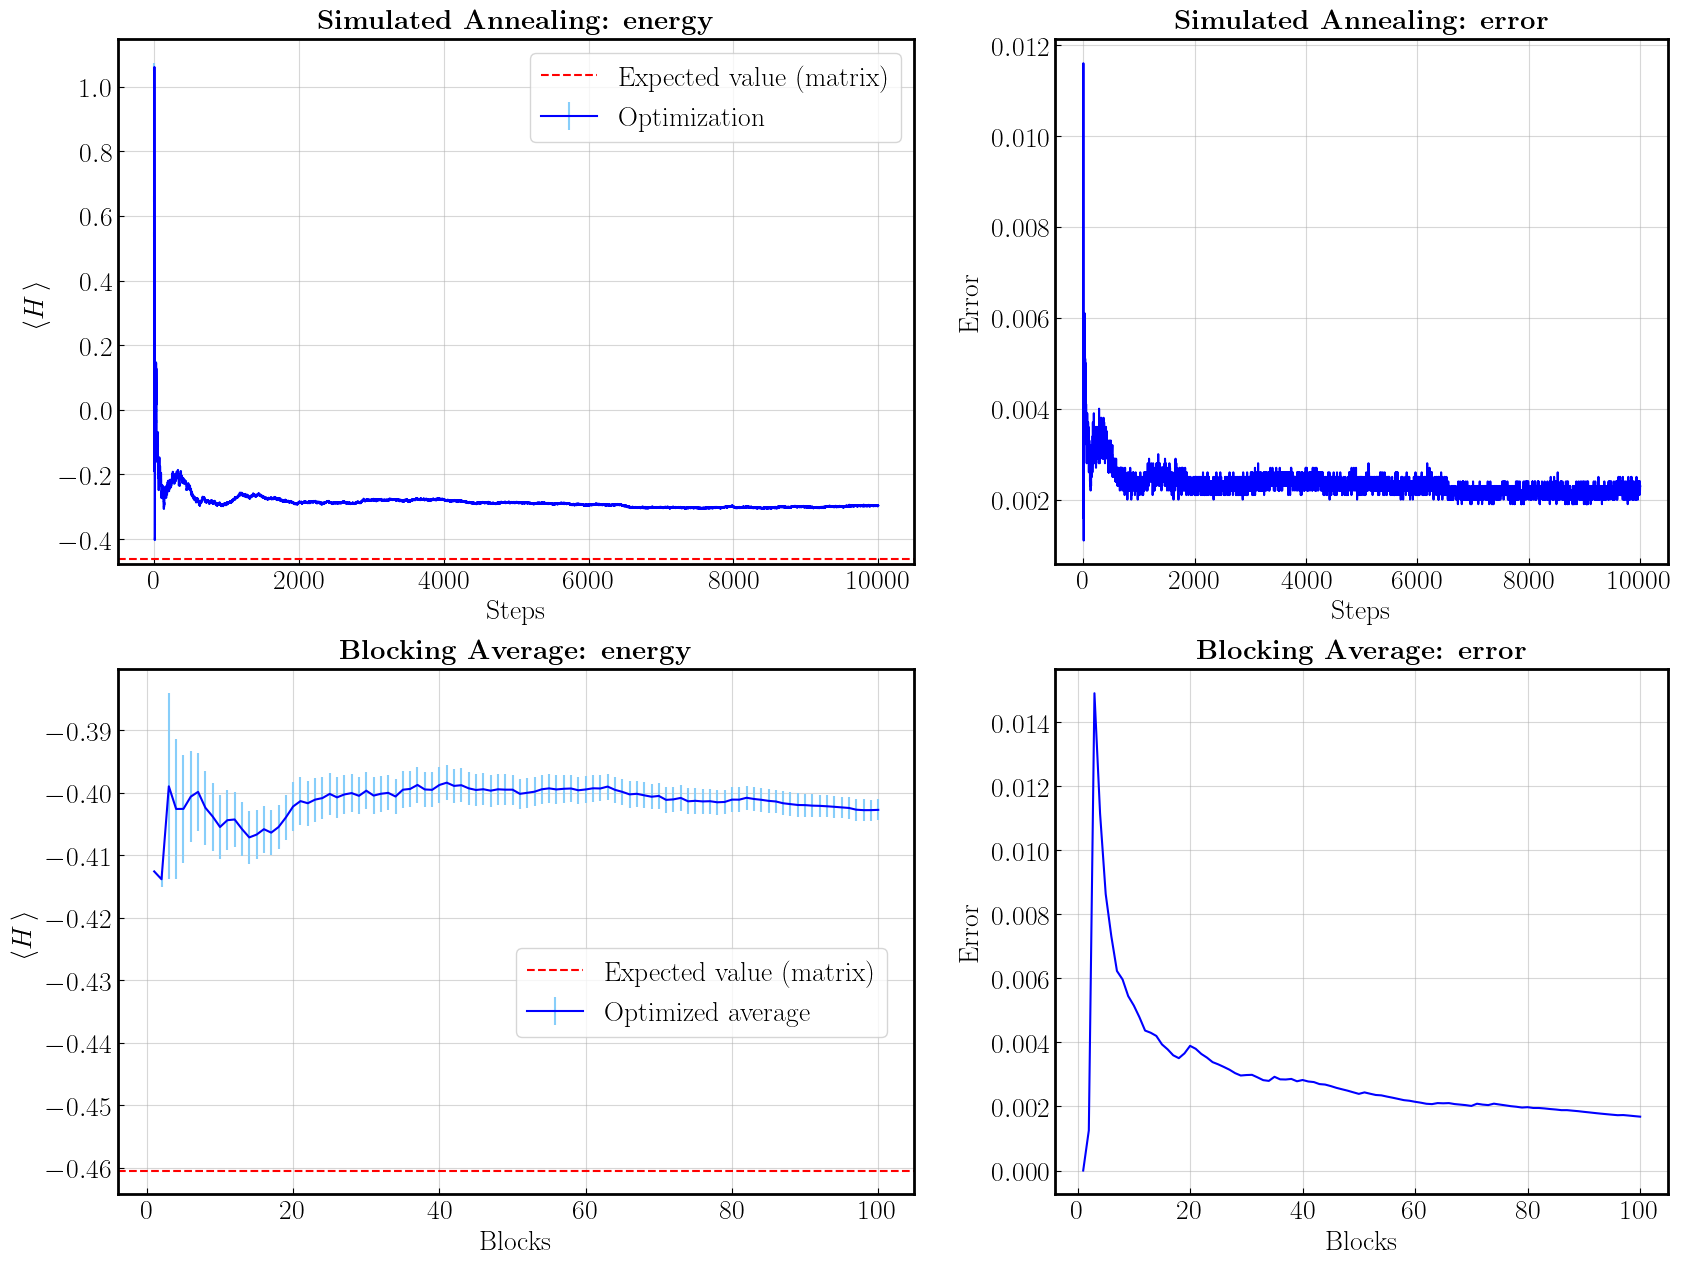

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15), gridspec_kw={'width_ratios': [1.3, 1], 'hspace': 0.2})

axs[0,0].errorbar(step, energy_opt, err_opt, c='blue', ecolor='lightskyblue', label='Optimization')
axs[0,0].axhline(y=E[0], c='red', linestyle='--', label='Expected value (matrix)')
axs[0,0].set_xlabel('Steps')
axs[0,0].set_ylabel(r'$\langle H \, \rangle$', labelpad=6)
axs[0,0].set_title(r'\textbf{Simulated Annealing: energy}', pad=8)
axs[0,0].legend()

axs[0,1].plot(step, err_opt, c='blue')
axs[0,1].set_xlabel('Steps')
axs[0,1].set_ylabel('Error', labelpad=6)
axs[0,1].set_title(r'\textbf{Simulated Annealing: error}', pad=8)

axs[1,0].errorbar(blocks, energy_best, err_best, c='blue', ecolor='lightskyblue', label='Optimized average')
axs[1,0].axhline(y=E[0], c='red', linestyle='--', label='Expected value (matrix)')
axs[1,0].set_xlabel('Blocks')
axs[1,0].set_ylabel(r'$\langle H \, \rangle$', labelpad=6)
axs[1,0].set_title(r'\textbf{Blocking Average: energy}', pad=8)
axs[1,0].legend(loc=(0.5,0.3))

axs[1,1].plot(blocks, err_best, c='blue')
axs[1,1].set_xlabel('Blocks')
axs[1,1].set_ylabel('Error', labelpad=6)
axs[1,1].set_title(r'\textbf{Blocking Average: error}', pad=8)

plt.show()

**Optimized parameters**:
- $\mu_{best} = 0.88327$
- $\sigma_{best} = 0.65409$ 

The upper plots show the evolution of the system energy during simulated annealing, with the error on the right. As $\mu$ and $\sigma$ get toward $\mu_{best}$ and $\sigma_{best}$, the energy decreases, though it doesn't reach the expected value, computed with the matrix equation in the supplementary material, due to limitations in the algorithm.

**Plot parameters**:
- SA steps: $10^4$

The lower plots show the blocking average value of the system energy and its error once we have optimized the parameters, i.e. using $\mu_{best}$ and $\sigma_{best}$. As we saw in the upper graphics, the algorithm converges to an upper bound for the ground state energy, again computed using the matrix representation.

**Plot parameters**:
- Total BA steps: $10^6$
- Blocks: $100$
- Steps in each block: $10^4$

In [11]:
mu_best     = 0.88327
sigma_best  = 0.65409

Fit parametrs:
	Mu: 0.883
	Sigma: 0.654
	Normalization: 0.371
Fit function:
	$\Psi(x) = \dfrac{1}{2 \cdot 0.654\cdot \sqrt{\pi} \cdot \Big(1 + e^{-\frac{0.883^2}{0.654^2}}\Big)} \cdot \left( e^{-\frac{(x - 0.883)^2}{2 \cdot0.654^2}} + e^{-\frac{(x + 0.883)^2}{2 \cdot0.654^2}} \right)$


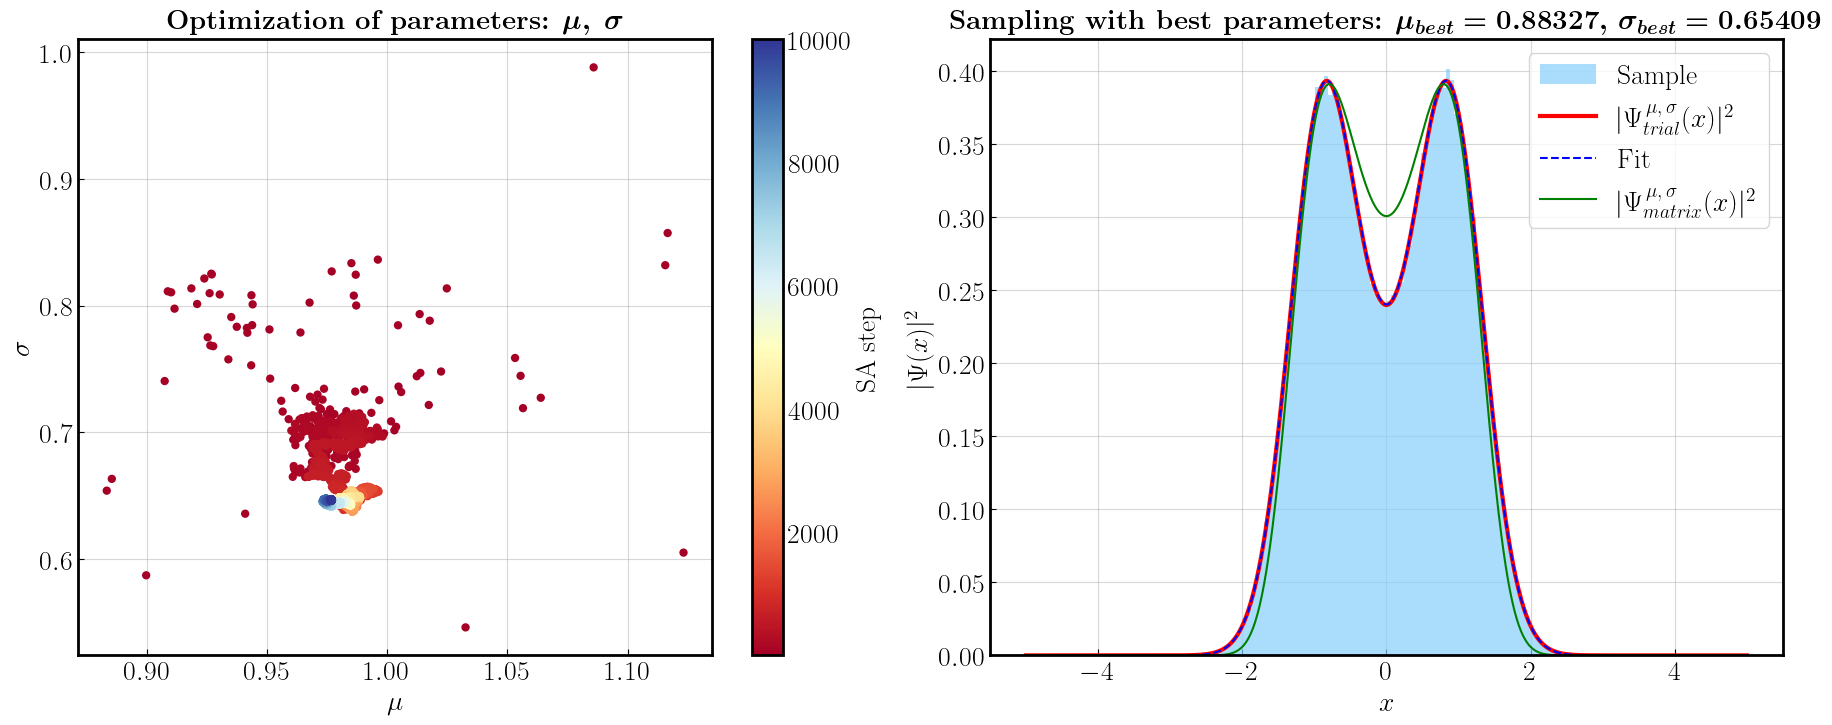

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(22, 8), gridspec_kw={'wspace': 0.15})

colors = step
scatter = axs[0].scatter(mu, sigma, c=colors, cmap='RdYlBu', edgecolors='none')
cbar = fig.colorbar(scatter, ax=axs[0])
cbar.set_label('SA step')
axs[0].set_xlabel('$\mu$')
axs[0].set_ylabel('$\sigma$')
axs[0].set_title(r'\textbf{Optimization of parameters:} \boldmath $\mu, \ \sigma$', pad=8)

hist = axs[1].hist(sampling, bins=100, density=True, color='lightskyblue', alpha=0.7, label="Sample")
axs[1].plot(x, wave_func(x, mu_best, sigma_best), c='red', lw=3, label='$|\Psi_{trial}^{\, \mu, \, \sigma}(x)|^2$')
popt, pcov = curve_fit(wave_func, hist[1][:-1], hist[0])
axs[1].plot(x, wave_func(x,*popt), c='blue', ls='--', label='Fit')
axs[1].plot(x, psi[0]**2, c='green', label='$|\Psi_{matrix}^{\, \mu, \, \sigma}(x)|^2$')

# printing the fitted wave function
mu_fit = popt[0]
mu_str = "{:.3f}".format(mu_fit)
sigma_fit = popt[1]
sigma_str = "{:.3f}".format(sigma_fit)
norm_fit = 2 * sigma_fit * np.sqrt(np.pi) * (1 + np.exp(-(mu_fit**2) / (sigma_fit**2)))
norm_str = "{:.3f}".format(1/norm_fit)
# (1/norm) * (np.exp(-(x - mu)**2 / (2*sigma**2)) + np.exp((-(x + mu)**2 / (2*sigma**2))))**2
print('Fit parametrs:\n\tMu: ' +mu_str+ '\n\tSigma: ' +sigma_str+ '\n\tNormalization: ' +norm_str)
print('Fit function:\n\t' + r'$\Psi(x) = \dfrac{1}{2 \cdot ' +sigma_str+ r'\cdot \sqrt{\pi} \cdot \Big(1 + e^{-\frac{' +mu_str+ r'^2}{' +sigma_str+ r'^2}}\Big)} \cdot \left( e^{-\frac{(x - ' +mu_str+ r')^2}{2 \cdot' +sigma_str+ r'^2}} + e^{-\frac{(x + ' +mu_str+ r')^2}{2 \cdot' +sigma_str+ r'^2}} \right)$')

axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$|\Psi(x)|^2$')
axs[1].set_title(r'\textbf{Sampling with best parameters:} \boldmath $\mu_{best}=' +str(mu_best)+ ', \, \sigma_{best}=' +str(sigma_best)+ '$', pad=8)
axs[1].legend()

plt.show()

The left plot shows the trajectory in the parameter space of the simulated annealing: at first (high temperatures) $\mu$ and $\sigma$ undergo great variations, and then they converge as the system cools down.

In the right plot I represented an histogram with the sampled trial wave function with the best parameters. The histogram is slightly different from the solution obtained with the matrix representation, but it sample very well $\Psi_T(x)$ with the best parameters. I also plotted a fit for the histogram, and we can notice that the fit parameters are equal to $\mu_{best}$ and $\sigma_{best}$:

$\Psi(x) = \dfrac{1}{2 \cdot 0.654\cdot \sqrt{\pi} \cdot \Big(1 + e^{-\frac{0.883^2}{0.654^2}}\Big)} \cdot \left( e^{-\frac{(x - 0.883)^2}{2 \cdot0.654^2}} + e^{-\frac{(x + 0.883)^2}{2 \cdot0.654^2}} \right)$


### Observations

- The results show that simulated annealing is a good method to find an approximation for the best parameter set, but it isn't perfect: we were able only to find an upper bound for the minimum energy. This may be due to the fact that we sampled a trial wave function, that was an approximation in any case.

- In general there is no unique way to map an optimization problem to a physical hamiltonian, and this may mean that there is a smarter way to use this algorithm. One thing that can be done to improve the results is to expand the explored temperature span, giving the system more time to find the minimum.